# Validation of the method for estimating CH4 climate impacts related to NOx emissions

In [1]:
import math
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from utils.functions import emission_profile_function
from metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from climate_models.co2_ipcc_climate_model import co2_ipcc_climate_model
from climate_models.gwpstar_climate_model import species_gwpstar_climate_model
from climate_models.lwe_climate_model import species_lwe_climate_model
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

In [2]:
erf_nox_lee_data_df = read_csv("climate_data/erf_nox_lee.csv", delimiter=";")
erf_nox_lee_data = erf_nox_lee_data_df.values
data_years = erf_nox_lee_data[:, 0]
data_nox_o3 = erf_nox_lee_data[:, 1]
data_nox_ch4_direct = erf_nox_lee_data[:, 2]
data_nox_ch4_o3 = erf_nox_lee_data[:, 3]
data_nox_ch4_swv = erf_nox_lee_data[:, 4]
data_nox_ch4 = data_nox_ch4_direct + data_nox_ch4_o3 + data_nox_ch4_swv
data_nox_o3_aeromaps = erf_nox_lee_data[:, 5]
data_nox_ch4_direct_aeromaps = erf_nox_lee_data[:, 6]
data_nox_ch4_o3_aeromaps = erf_nox_lee_data[:, 7]
data_nox_ch4_swv_aeromaps = erf_nox_lee_data[:, 8]
data_nox_ch4_aeromaps = data_nox_ch4_direct_aeromaps + data_nox_ch4_o3_aeromaps + data_nox_ch4_swv_aeromaps

## Parameters

In [3]:
unit_value_o3 = 1
sensitivity_erf_o3 = 34.4e-12 * (14/46)
ratio_erf_rf_o3 = 1.37
efficacy_erf_o3 = 1

unit_value_ch4 = 1
sensitivity_erf_ch4 = -0.98e-9
sensitivity_erf_ch4_gwpstar = -30.8e-12 * (14/46) * 0.77 # Mean value for transcient coefficient from Lee et al.
ratio_erf_rf_ch4 = 1.18
efficacy_erf_ch4 = 1

start_year = 1940
end_year = 2050
tcre = 0.00045
background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')

In [4]:
klower_data_df = read_csv("climate_data/historical_data_from_klower.csv", delimiter=";")
klower_data = klower_data_df.values
klower_data_years = klower_data[:, 0]
klower_data_co2 = klower_data[:, 1]
klower_data_distance = klower_data[:, 2]
aeromaps_data_co2 = klower_data[:, 3]

years_total = np.zeros(2050-1940+1)
for k in range(0, 2018-1940+1):
    years_total[k] = klower_data_years[k]
for k in range(2018-1940+1, len(years_total)):
    years_total[k] = years_total[k-1] + 1

species_quantities = np.zeros(2050-1940+1)
emission_index_nox = 0.01514
for k in range(0, 2018-1940+1):
    species_quantities[k] = klower_data_co2[k] / 3.15 * emission_index_nox * 1e9 # [MtNOx to kgNOx]
for k in range(2018-1940+1, len(years_total)):
    species_quantities[k] = 0

## Metrics calculation

In [5]:
species_settings_o3 = {"sensitivity_erf": sensitivity_erf_o3, "ratio_erf_rf": ratio_erf_rf_o3, "efficacy_erf": efficacy_erf_o3}
species_settings_ch4 = {"sensitivity_erf": sensitivity_erf_ch4, "ratio_erf_rf": ratio_erf_rf_ch4, "efficacy_erf": efficacy_erf_ch4}
species_settings_ch4_gwpstar = {"sensitivity_erf": sensitivity_erf_ch4_gwpstar, "ratio_erf_rf": ratio_erf_rf_ch4, "efficacy_erf": efficacy_erf_ch4}
model_settings = {"tcre": tcre}
model_settings_fair = {"background_species_quantities": background_species_quantities}

radiative_forcing_o3_gwpstar, effective_radiative_forcing_o3_gwpstar, temperature_o3_gwpstar = species_gwpstar_climate_model(start_year, end_year, "Aviation NOx - ST O3 increase", species_quantities, species_settings_o3, model_settings)
radiative_forcing_o3_lwe, effective_radiative_forcing_o3_lwe, temperature_o3_lwe = species_lwe_climate_model(start_year, end_year, "Aviation NOx - ST O3 increase", species_quantities, species_settings_o3, model_settings)
radiative_forcing_o3_fair, effective_radiative_forcing_o3_fair, temperature_o3_fair = species_fair_climate_model(start_year, end_year, "Aviation NOx - ST O3 increase", species_quantities, species_settings_o3, model_settings_fair)

radiative_forcing_ch4_gwpstar, effective_radiative_forcing_ch4_gwpstar, temperature_ch4_gwpstar = species_gwpstar_climate_model(start_year, end_year, "Aviation NOx - CH4 decrease and induced", species_quantities, species_settings_ch4_gwpstar, model_settings)
radiative_forcing_ch4_lwe, effective_radiative_forcing_ch4_lwe, temperature_ch4_lwe = species_lwe_climate_model(start_year, end_year, "Aviation NOx - CH4 decrease and induced", species_quantities, species_settings_ch4, model_settings)
radiative_forcing_ch4_fair, effective_radiative_forcing_ch4_fair, temperature_ch4_fair = species_fair_climate_model(start_year, end_year, "Aviation NOx - CH4 decrease and induced", species_quantities, species_settings_ch4, model_settings_fair)

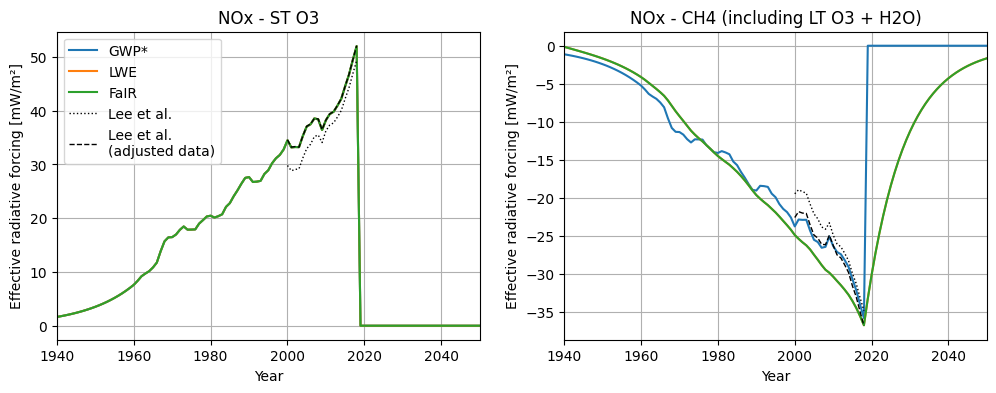

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(years_total, 1000 * effective_radiative_forcing_o3_gwpstar, label='GWP*')
        ax.plot(years_total, 1000 * effective_radiative_forcing_o3_lwe, label='LWE')
        ax.plot(years_total, 1000 * effective_radiative_forcing_o3_fair, label='FaIR')
        ax.plot(data_years, data_nox_o3, label='Lee et al.', color='black', linestyle=":", linewidth=1)
        ax.plot(data_years, data_nox_o3_aeromaps, label='Lee et al.\n(adjusted data)', color='black', linestyle="--", linewidth=1)
        ax.legend()
    elif i == 1:
        ax.plot(years_total, 1000 * effective_radiative_forcing_ch4_gwpstar, label='GWP*')
        ax.plot(years_total, 1000 * effective_radiative_forcing_ch4_lwe, label='LWE')
        ax.plot(years_total, 1000 * effective_radiative_forcing_ch4_fair, label='FaIR')
        ax.plot(data_years, data_nox_ch4, label='Lee et al.', color='black', linestyle=":", linewidth=1)
        ax.plot(data_years, data_nox_ch4_aeromaps, label='Lee et al.\n(adjusted data)', color='black', linestyle="--", linewidth=1)
    ax.set_xlim(start_year, end_year)
    ax.set_xlabel('Year')
    ax.set_ylabel('Effective radiative forcing [mW/m²]')
    ax.grid(True)
    if i == 0:
        ax.set_title('NOx - ST O3')
    elif i == 1:
        ax.set_title('NOx - CH4 (including LT O3 + H2O)')
    
plt.show()

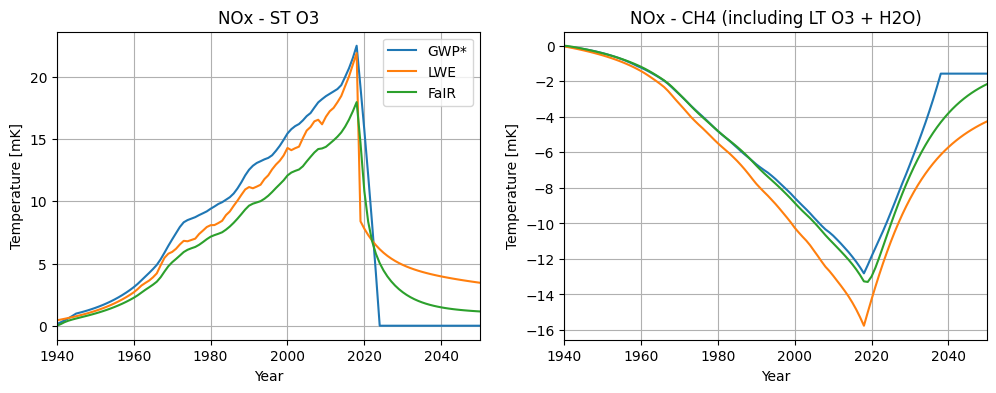

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(years_total, 1000 * temperature_o3_gwpstar, label='GWP*')
        ax.plot(years_total, 1000 * temperature_o3_lwe, label='LWE')
        ax.plot(years_total, 1000 * temperature_o3_fair, label='FaIR')
        ax.legend()
    elif i == 1:
        ax.plot(years_total, 1000 * temperature_ch4_gwpstar, label='GWP*')
        ax.plot(years_total, 1000 * temperature_ch4_lwe, label='LWE')
        ax.plot(years_total, 1000 * temperature_ch4_fair, label='FaIR')
    ax.set_xlim(start_year, end_year)
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature [mK]')
    ax.grid(True)
    if i == 0:
        ax.set_title('NOx - ST O3')
    elif i == 1:
        ax.set_title('NOx - CH4 (including LT O3 + H2O)')
    
plt.show()